In [61]:
import pandas as pd
import numpy as np

In [62]:
mapping = pd.read_csv("../csv_files/bookstore_csv/mapping.csv")
d_type = {"commit_hash" : "str", 	"num_additions" : int,	"num_deletions": int, "filename" : "str"}

def load_data(file):
    df = pd.read_csv(file)
    df = df[df.filename.str.endswith(".java")]
    return pd.DataFrame({"commit_hash": df.commit_hash, "changes": pd.to_numeric(df.num_additions) + pd.to_numeric(df.num_deletions), "filename": df.filename})

data_java = load_data("../csv_files/bookstore_csv/output_java.csv")
data_ast = load_data("../csv_files/bookstore_csv/output_ast.csv")
data_java_nws = load_data("../csv_files/bookstore_csv/output_nws.csv")

In [63]:
mapping

,from,to
0,8a3399aec8341c0766a49826a023bb6b24562ec1,be9474a1320a2585581151aa211cf662595f593e
1,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,566fe922671b6a1941400d381e63ce20c04d953a
2,7ee02cf2e1405fb376a7f0d9f10c53628ba18373,1c0a15bde391be864031fabdfb0389a2d5e5d8df
3,9f0a5c0e2efd594dfc93a7440f8965860b0fcfe0,ae9b5426c6c3da90531945dd539dee95f7a35cff
4,38443e531a68d35f9c3be2fcdbe749b3da232963,130f2baf932c7ea9c2885581b92b420091c7ce63
...,...,...
190,59e4f86a4d265dd166aaabb5fd3277b07668881f,29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0
191,04bfbd44fc64324dceab22b069c90bb723ea9c49,e9d12bae3cc9fd9c856575e3f15a180b4ab37dc7
192,7f69dcee1135798e8b06e2fbf8539f7f04adb6d6,673aaee97c59baaccc653a37e6989bd01297e78c
193,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,c8876b959f65f3eedcc4b35700398d8aaece0452


In [64]:
data_ast

,commit_hash,changes,filename
0,c8876b959f65f3eedcc4b35700398d8aaece0452,21,src/main/java/com/bittercode/util/StoreUtil.java
1,c8876b959f65f3eedcc4b35700398d8aaece0452,18,src/main/java/servlets/CartServlet.java
2,c8876b959f65f3eedcc4b35700398d8aaece0452,114,src/main/java/servlets/ViewBookServlet.java
8,29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0,435,src/main/java/com/bittercode/util/StoreUtil.java
9,29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0,200,src/main/java/servlets/AboutServlet.java
...,...,...,...
532,566fe922671b6a1941400d381e63ce20c04d953a,450,OnlineBookStore/src/test/ReceiptServlet.java
533,566fe922671b6a1941400d381e63ce20c04d953a,208,OnlineBookStore/src/test/RemoveBookServlet.java
534,566fe922671b6a1941400d381e63ce20c04d953a,240,OnlineBookStore/src/test/UserLoginServlet.java
535,566fe922671b6a1941400d381e63ce20c04d953a,313,OnlineBookStore/src/test/UserRegisterServlet.java


In [65]:
data_java

,commit_hash,changes,filename
0,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,25,src/main/java/com/bittercode/util/StoreUtil.java
1,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,20,src/main/java/servlets/CartServlet.java
2,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,65,src/main/java/servlets/ViewBookServlet.java
8,59e4f86a4d265dd166aaabb5fd3277b07668881f,105,src/main/java/com/bittercode/util/StoreUtil.java
9,59e4f86a4d265dd166aaabb5fd3277b07668881f,35,src/main/java/servlets/AboutServlet.java
...,...,...,...
540,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,75,OnlineBookStore/src/test/ReceiptServlet.java
541,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,39,OnlineBookStore/src/test/RemoveBookServlet.java
542,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,42,OnlineBookStore/src/test/UserLoginServlet.java
543,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,47,OnlineBookStore/src/test/UserRegisterServlet.java


In [66]:
df_ast = pd.merge(data_ast, mapping, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_ast"}).drop(columns=["to", "commit_hash_ast"]).set_index(["commit_hash", "filename"])

In [67]:
df_java = data_java.set_index(["commit_hash", "filename"])


In [68]:
df_java_nws = data_java_nws.set_index(["commit_hash", "filename"])

In [69]:
def mergeall(**dfs):
    from functools import reduce
    items = dfs.items()
    table = df_java.rename(columns = dict(changes="repo"))
    for key, df in items:
        table = pd.merge(table, df.rename(columns = dict(changes=key)), left_index=True, right_index=True, validate="1:1", how="outer")
    return table

df_merged = mergeall(token= df_ast, nws= df_java_nws).fillna(0, downcast="int64")
df_merged.isna().sum()

repo     0
token    0
nws      0
dtype: int64

<Axes: xlabel='commit_hash,filename'>

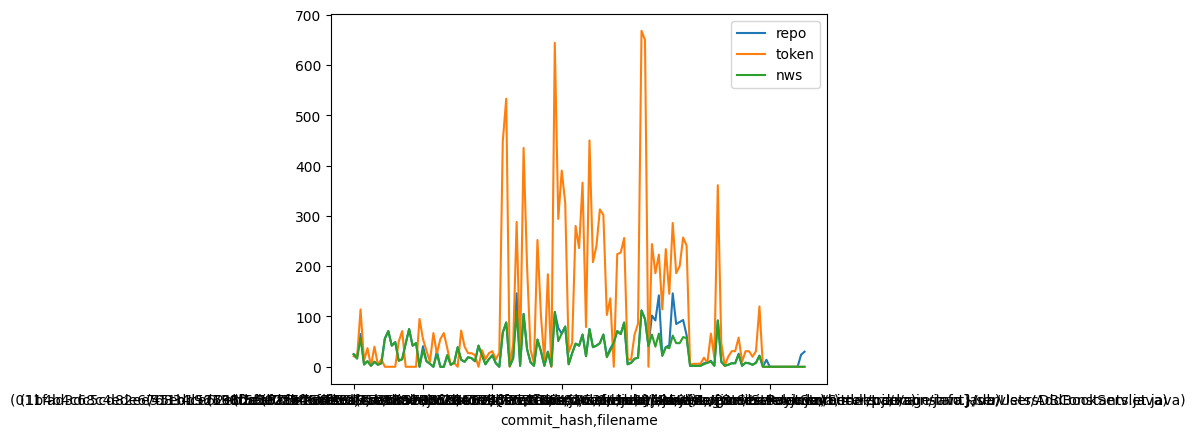

In [70]:
df_merged.plot()

<Axes: >

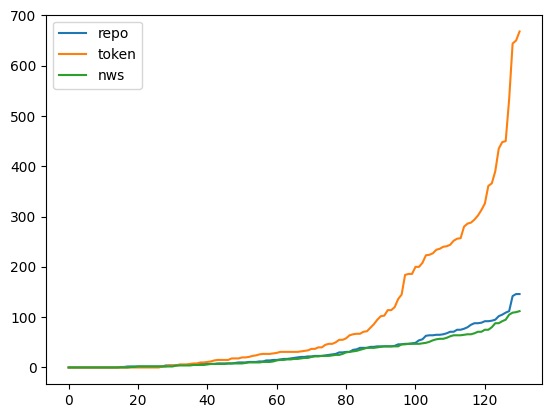

In [71]:
df = pd.DataFrame({k : np.array(df_merged[k].sort_values()) for k in df_merged.columns})
df.plot()

In [72]:
df_nws = pd.DataFrame({"java": np.array(df_merged_nws.changes.sort_values()), "ast": np.array(df_merged_nws.changes_ast.sort_values())})
df_nws.plot()

NameError: name 'df_merged_nws' is not defined

In [ ]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
(df / df.sum()).plot()

AttributeError: 'DataFrame' object has no attribute 'changes'

In [ ]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
(df.cumsum() / df.sum()).plot()
df

AttributeError: 'DataFrame' object has no attribute 'changes'

In [ ]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
df.cumsum().plot()

AttributeError: 'DataFrame' object has no attribute 'changes'

In [ ]:
df = pd.DataFrame({"java": df_merged.changes, "ast": df_merged.changes_ast})
(df.cumsum() / df.sum()).plot()

AttributeError: 'DataFrame' object has no attribute 'changes'

In [ ]:
#find størrelsen af filen for at finde en relativ ændring 
df_merged[df_merged.token == 0][df_merged.nws != 0]

C:\Users\boran\AppData\Local\Temp\ipykernel_28460\4186556791.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merged[df_merged.token == 0][df_merged.nws != 0]


repo  \
commit_hash                              filename                                                   
1b4b4c68c4ede676834ce62eb2d1f014fe3489a7 OnlineBookStore/servlets/AddBookServlet.java          56   
                                         OnlineBookStore/servlets/ReceiptServlet.java          71   
                                         OnlineBookStore/servlets/UserLoginServlet.java        42   
                                         OnlineBookStore/servlets/UserRegisterServlet.java     49   
                                         OnlineBookStore/src/test/AddBookServlet.java          46   
                                         OnlineBookStore/src/test/ReceiptServlet.java          75   
                                         OnlineBookStore/src/test/UserLoginServlet.java        42   
                                         OnlineBookStore/src/test/UserRegisterServlet.java     47   
45edd52796dc2025b46c9592678dc9be5f2b4178 src/main/java/config/DBConnection.java                39   
                                         src/main/java/servlets/DBConnection.java              42   
4a307fabea604be9cb5bf92a5c65c29e9f0028f4 src/main/java/servlets/ReceiptServlet.java             1   
668f6fb87f546fdb6d61b19913868ae6cb37c588 src/main/java/com/bittercode/service/impl/UserS...     1   
ba5e7a6d5df4ca95e2306c062947e5df3b1026cd src/main/java/com/bittercode/config/DBUtil.java       48   
                                         src/main/java/config/DBConnection.java                41   

                                                                                             token  \
commit_hash                              filename                                                    
1b4b4c68c4ede676834ce62eb2d1f014fe3489a7 OnlineBookStore/servlets/AddBookServlet.java            0   
                                         OnlineBookStore/servlets/ReceiptServlet.java            0   
                                         OnlineBookStore/servlets/UserLoginServlet.java          0   
                                         OnlineBookStore/servlets/UserRegisterServlet.java       0   
                                         OnlineBookStore/src/test/AddBookServlet.java            0   
                                         OnlineBookStore/src/test/ReceiptServlet.java            0   
                                         OnlineBookStore/src/test/UserLoginServlet.java          0   
                                         OnlineBookStore/src/test/UserRegisterServlet.java       0   
45edd52796dc2025b46c9592678dc9be5f2b4178 src/main/java/config/DBConnection.java                  0   
                                         src/main/java/servlets/DBConnection.java                0   
4a307fabea604be9cb5bf92a5c65c29e9f0028f4 src/main/java/servlets/ReceiptServlet.java              0   
668f6fb87f546fdb6d61b19913868ae6cb37c588 src/main/java/com/bittercode/service/impl/UserS...      0   
ba5e7a6d5df4ca95e2306c062947e5df3b1026cd src/main/java/com/bittercode/config/DBUtil.java         0   
                                         src/main/java/config/DBConnection.java                  0   

                                                                                             nws  
commit_hash                              filename                                                 
1b4b4c68c4ede676834ce62eb2d1f014fe3489a7 OnlineBookStore/servlets/AddBookServlet.java         56  
                                         OnlineBookStore/servlets/ReceiptServlet.java         71  
                                         OnlineBookStore/servlets/UserLoginServlet.java       42  
                                         OnlineBookStore/servlets/UserRegisterServlet.java    49  
                                         OnlineBookStore/src/test/AddBookServlet.java         46  
                                         OnlineBookStore/src/test/ReceiptServlet.java         75  
                                         OnlineBook

In [ ]:
from tree_sitter import Language, Parser
import os
from formast.__main__ import JAVA_LANGUAGE

parser = Parser()
parser.set_language(JAVA_LANGUAGE)



with open("..\java_files\simple.java", "rb") as f:
    code = f.read()
tree = parser.parse(code)

tree.root_node.children[0].children

<Node type=program, start_point=(0, 0), end_point=(0, 17)>

In [ ]:
def traverse(tree, depth=1):
    cursor = tree.walk()
    descend = [True]

    while True:
        if descend[-1]:
            yield cursor.node, depth
        if descend[-1] and cursor.goto_first_child():
            descend[-1] = False
            descend.append(True)
            if cursor.node.type == "for_statement":
                yield None, depth+1
        elif cursor.goto_next_sibling():
            descend[-1] = True
        elif cursor.goto_parent():
            descend.pop()
        else:
            break

def save_ast_file(file_path, tree):
    with open(file_path+".ast2", 'w') as f:
        for node in traverse(tree):
            if node.child_count == 0:
                f.write(node.text.decode("utf8"))
                f.write("\n")

In [ ]:
# result = traverse(tree, depth=1)
# save_ast_file("trying",result)

In [1]:
from collections import deque
from tree_sitter import Language, Parser
import os
from formast.__main__ import JAVA_LANGUAGE

parser = Parser()
parser.set_language(JAVA_LANGUAGE)

with open("..\java_files\simple.java", "rb") as f:
    code = f.read()
tree = parser.parse(code)

tree

In [14]:
from tree_sitter import Node

def print_node(node: Node, indent: str = ""):
    print(f"{indent}{node.type} [{node.start_point[0]}, {node.start_point[1]}] - [{node.end_point[0]}, {node.end_point[1]}]")
    for child in node.children:
        print_node(child, indent + "  ")

print_node(tree.root_node)

program [0, 0] - [0, 17]
  class_declaration [0, 0] - [0, 17]
    modifiers [0, 0] - [0, 6]
      public [0, 0] - [0, 6]
    class [0, 7] - [0, 12]
    identifier [0, 13] - [0, 14]
    class_body [0, 15] - [0, 17]
      { [0, 15] - [0, 16]
      } [0, 16] - [0, 17]


In [16]:
# Works quite well but has B class
def process_tree(tree, code):
    lines = []
    def process_node(node):
        if node.type == 'identifier':
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            lines.append(f'B identifier {len(lines) - 1}')
            return len(lines) - 1
        elif node.type == 'class_body':
            children = []
            for child in node.children:
                if child.type not in ['{', '}']:
                    child_index = process_node(child)
                    if child_index is not None:
                        children.append(child_index)
            lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
        else:
            children = []
            for child in node.children:
                child_index = process_node(child)
                if child_index is not None:
                    children.append(child_index)
            lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
    process_node(tree.root_node)
    return '\n'.join(lines)

print(process_tree(tree, code))

B public 
B modifiers 0
B class 
N A
B identifier 3
B class_body 
B class_declaration 1 2 4 5
B program 6


In [17]:
# Same as before, but skips B class
def process_tree(tree, code):
    lines = []
    def process_node(node):
        if node.type == 'identifier':
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            lines.append(f'B identifier {len(lines) - 1}')
            return len(lines) - 1
        elif node.type == 'class':
            return None
        elif node.type == 'class_body':
            children = []
            for child in node.children:
                if child.type not in ['{', '}']:
                    child_index = process_node(child)
                    if child_index is not None:
                        children.append(child_index)
            lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
        else:
            children = []
            for child in node.children:
                child_index = process_node(child)
                if child_index is not None:
                    children.append(child_index)
            lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
    process_node(tree.root_node)
    return '\n'.join(lines)

print(process_tree(tree, code))

B public 
B modifiers 0
N A
B identifier 2
B class_body 
B class_declaration 1 3 4
B program 5


In [204]:
def process_tree(tree, code):
    lines = []
    def process_node(node):
        if node.type == 'identifier' or (node.type == 'public' and node.parent.type == 'modifiers'):
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            return len(lines) - 1
        elif node.type == '{' or node.type == '}':
            return None
        else:
            children = []
            for child in node.children:
                child_index = process_node(child)
                if child_index is not None:
                    children.append(child_index)
            if node.type == 'class_declaration':
                lines.append(f'B identifier {children[1]}')
                children[1] = len(lines) - 1
            lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
    process_node(tree.root_node)
    return '\n'.join(lines)

print(process_tree(tree, code))

N public
B modifiers 0
B class 
N A
B class_body 
B identifier 2
B class_declaration 1 5 3 4
B program 6


In [205]:
def process_tree(tree, code):
    lines = []
    def process_node(node):
        if node.type == 'identifier':
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            return len(lines) - 1
        else:
            children = []
            for child in node.children:
                child_index = process_node(child)
                if child_index is not None:
                    children.append(child_index)
            lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
    process_node(tree.root_node)
    return '\n'.join(lines)


print(process_tree(tree, code))


B public 
B modifiers 0
B class 
N A
B { 
B } 
B class_body 4 5
B class_declaration 1 2 3 6
B program 7


In [198]:
def process_tree(tree, code):
    lines = []
    def process_node(node):
        if node.type == 'identifier' or (node.type == 'public' and node.parent.type == 'modifiers'):
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            return len(lines) - 1
        else:
            children = []
            for child in node.children:
                child_index = process_node(child)
                if child_index is not None:
                    children.append(child_index)
            if node.type == 'identifier':
                lines.append(f'B {node.parent.type} {" ".join(map(str, children))}')
            else:
                lines.append(f'B {node.type} {" ".join(map(str, children))}')
            return len(lines) - 1
    process_node(tree.root_node)
    return '\n'.join(lines)

print(process_tree(tree, code))


N public
B modifiers 0
B class 
N A
B { 
B } 
B class_body 4 5
B class_declaration 1 2 3 6
B program 7


In [196]:
def process_tree(tree, code):
    lines = []
    
    def process_node(node):
        nonlocal lines
        
        if node.type == 'identifier' or (node.type == 'public' and node.parent.type == 'modifiers'):
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            return len(lines) - 1
        
        children = []
        for child in node.children:
            child_index = process_node(child)
            if child_index is not None:
                children.append(child_index)
        
        node_type = node.type if node.type != 'identifier' else node.parent.type
        lines.append(f'B {node_type} {" ".join(map(str, children))}')
        return len(lines) - 1
    
    process_node(tree.root_node)
    return '\n'.join(lines)

print(process_tree(tree,code))

N public
B modifiers 0
B class 
N A
B { 
B } 
B class_body 4 5
B class_declaration 1 2 3 6
B program 7


In [179]:
def process_tree(tree, code):
    lines = []
    stack = [(tree.root_node, None)]
    while stack:
        node, parent_index = stack.pop()
        if node.type == 'identifier' or (node.type == 'public' and node.parent.type == 'modifiers'):
            lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
            parent_index = len(lines) - 1
        children = []
        for child in reversed(node.children):
            child_index = stack[-1][1] if stack else None
            if child.type != 'ERROR':
                stack.append((child, child_index))
                children.append(len(lines))
        if parent_index is not None:
            node_type = node.parent.type if node.type == 'identifier' else node.type
            lines.append(f'B {node_type} {" ".join(map(str, reversed(children)))}')
    return '\n'.join(lines)

print(process_tree(tree,code))

N public
B public 
N A
B class_declaration 


In [159]:
def traverse(node):
    yield node
    if node.children:
        for child in node.children:
            yield from traverse(child)

oi = traverse(tree.root_node)
#for i in oi:
#    print(i)

def generate_ast_tree(node):
    Node = "N"
    Branch = "B"
    Leaf = "L"
    line = 0
    for node in traverse(node):
        if node.children:
            for child in node.children:
                yield f"{Node} {child.type} {line}"
        yield f"{Node} {child.type} {line}"
        line=+1
        

oi=generate_ast_tree(tree.root_node)
for i in oi:
    print(i)
            

N class_declaration 0
N class_declaration 0
N modifiers 1
N class 1
N identifier 1
N class_body 1
N class_body 1
N public 1
N public 1
N public 1
N public 1
N public 1
N { 1
N } 1
N } 1
N } 1
N } 1


In [95]:
def traverse(node):
    yield node
    if node.children:
        for child in node.children:
            yield from traverse(child)

def generate_ast(tree):
    root_node = tree.root_node
    output = []
    indent = ''
    line_no = 0

    for node in traverse(root_node):
        if node.is_named:
            type = node.type
            start_row, start_col = node.start_point
            end_row, end_col = node.end_point
            if node.child_count > 0:
                output.append(f"{line_no:02d} | N {type}")
                output.append(f"{line_no:02d} | B {type} {start_row}:{start_col}-{end_row}:{end_col}")
                indent += '  '
            else:
                output.append(f"{line_no:02d} | N {type} {node.text}")
                indent = '  '
        else:
            indent = indent[:-2]

        line_no += 1
        output.append(f"{line_no:02d} | {indent}B {node.type} {node.start_point[0]}:{node.start_point[1]}-{node.end_point[0]}:{node.end_point[1]}")

    return '\n'.join(output)



In [120]:
oi=traverse(tree.root_node)
for i in oi:
    print(i)

def generate_ast(root_node):
    Node = "N"
    Branch = "B" 
    line = 0   
    for node in traverse(root_node):
        if node.is_named:
            if node.child_count > 0:
                # yield f"{line:02d} | N {type}"
                yield f"{Node} {node.type}"
                # go to child node
                node = node.children[0]
                yield f"{Branch} {node.type} {line}"
                # check if there is a sibling other than the current node
                if node.next_sibling:
                    node = node.next_sibling
                    yield f"{Branch} {node.type} {line}"
            else:
                yield f"{Node} {node.type} {node.text}"
    return

oi = generate_ast(tree.root_node)
for i in oi:
    print(i)


<Node type=program, start_point=(0, 0), end_point=(0, 17)>
<Node type=class_declaration, start_point=(0, 0), end_point=(0, 17)>
<Node type=modifiers, start_point=(0, 0), end_point=(0, 6)>
<Node type="public", start_point=(0, 0), end_point=(0, 6)>
<Node type="class", start_point=(0, 7), end_point=(0, 12)>
<Node type=identifier, start_point=(0, 13), end_point=(0, 14)>
<Node type=class_body, start_point=(0, 15), end_point=(0, 17)>
<Node type="{", start_point=(0, 15), end_point=(0, 16)>
<Node type="}", start_point=(0, 16), end_point=(0, 17)>
N program
B class_declaration 0
N class_declaration
B modifiers 0
B class 0
N modifiers
B public 0
N identifier b'A'
N class_body
B { 0
B } 0
